# Case 1: House price prediction

In this case (Part II), there are two main tasks:

- First, you will need to split the train data into train and validate data and tune the model hyperparameters to choose the best model. Submit the predicted prices for test data to Kaggle to compete for Prof. X's Prize!

- Then you will examine the profit of the iBuyer business model based on the predicted price on the valid data.






## Instructions

You need to submit a report in pdf format containing the following material on canvas site:

1.   A plot of the training errors and validation errors over epochs for a base multilayer perceptron model with 2 hidden layers of sizes 256 and 128.

2.   A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64.

3.  A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization.

4. A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization and dropout layers.

5. A table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.

6. Your profit analysis of the the iBuyer business model based on the predicted price on the valid data and answers to the four questions therein.


You also need to submit on canvas site:

- The complete Juyputer notebook containing all your Pytorch code with explanations, along with a Markdown text explaining different parts if needed.
-  A checkpoint.pth file containing all the necessary information to retrieve your best model and predictions.



---

## Data Loading and Visualize Data

The train data and test data are available on Kaggle website.
You can first download them, then upload them to the google colab, and then read the data using pandas.

In [ ]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis
# Read the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Let's take a quick look at the data

In [ ]:
# Display the train dataframe
print(train_df.shape)
print(train_df.columns)

(11581, 17)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS', 'SALE_PRICE'],
      dtype='object')


In [ ]:
# Display the test dataframe
print(test_df.shape)
print(test_df.columns)

(4964, 16)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS'],
      dtype='object')


As you can see, we have 11581 training samples and 4964 test samples, each with 16 features. The training samples contain the sale_prices, which are the labels. The test samples do not contain the sale_prices, which we will predict by building a MLP model.


### Visualization of SALE PRICES

Let's take a closer look at the sale prices in the train data.

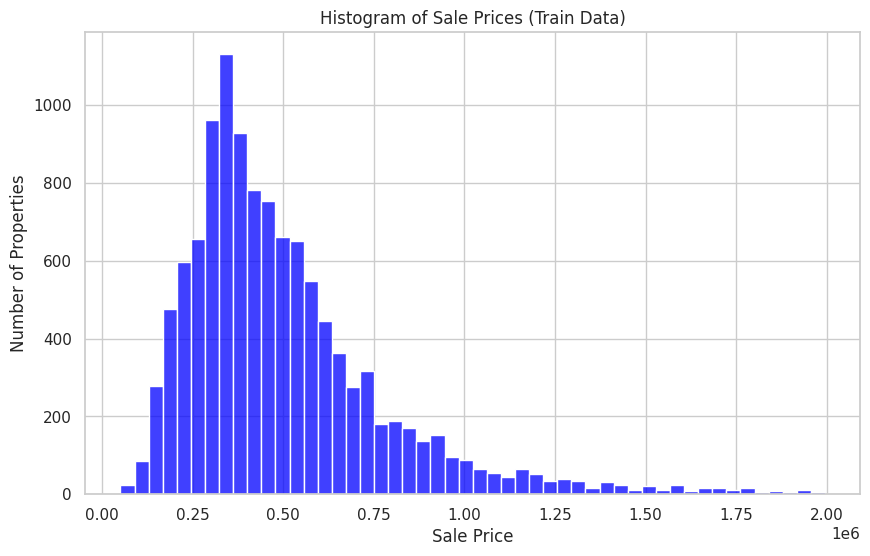

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot, it provides a MATLAB-like interface for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

Check the minimum and maximum sale_price in train data.

In [ ]:
print(train_df['SALE_PRICE'].min())
print(train_df['SALE_PRICE'].max())
print(train_df['SALE_PRICE'].median())

51000
1995000
431000.0


We see that the sale_price has a wide range from 50K to 2 million, with the median price 431K.

### Visualization of Correlation

We can also compute and visualize the correlation matrix.

<ipython-input-6-28da14c2e215>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


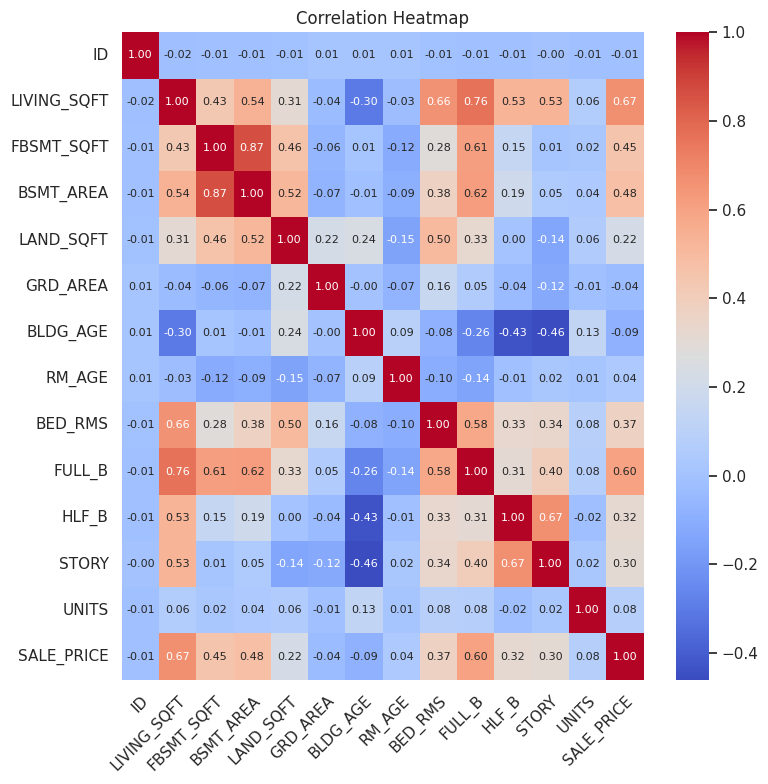

In [ ]:
# Compute the correlation matrix:
correlation_matrix = train_df.corr()

# 1. Increase the figure size for clarity
plt.figure(figsize=(8, 8))

# 2. Use a heatmap with annotations, a color map, and specific formatting for the annotations
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})

# 3. Rotate the x-axis labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=0)

# 4. Title and display
plt.title('Correlation Heatmap')
plt.tight_layout()  # This can help if any labels are still being cut off
plt.show()

# 5. Optionally save the figure with high resolution
# plt.savefig("heatmap.png", dpi=300)

We can see that the Sale_Price has high correlation with Living_SQFT and number of Full Bathrooms.

### Distribution of houses over different NBHD

In [ ]:
# Compute the number of houses per neighborhood
House_by_NBHD = train_df['NBHD'].value_counts()
print(House_by_NBHD )

CENTRAL PARK                    1049
GATEWAY / GREEN VALLEY RANCH     937
UNION STATION                    369
HAMPDEN                          346
WINDSOR                          316
                                ... 
VALVERDE                          22
GLOBEVILLE                        20
SUN VALLEY                         8
CORY - MERRILL                     4
AURARIA                            1
Name: NBHD, Length: 75, dtype: int64


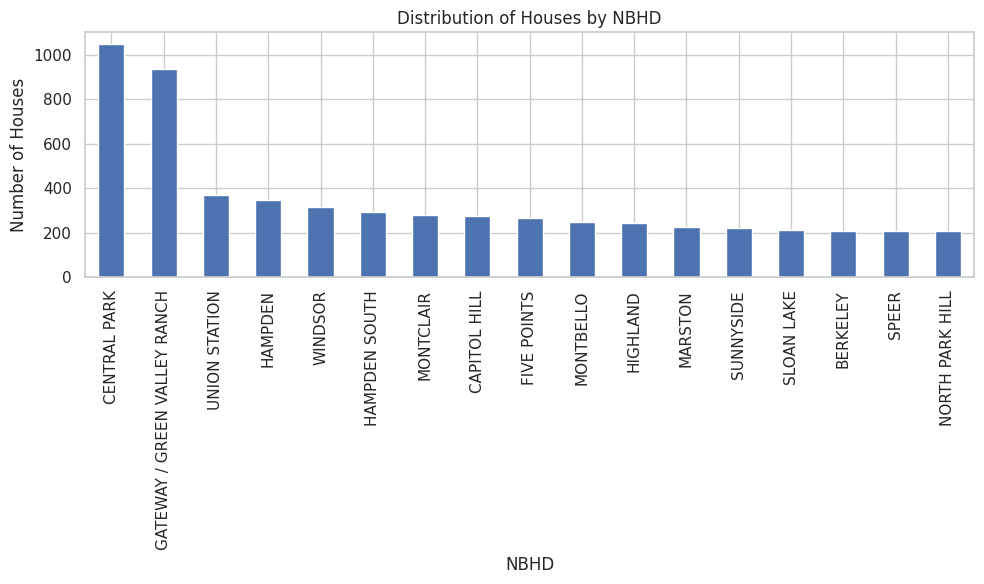

In [ ]:
# Filtering ZIP codes that appear more than once
filtered_House_by_NBHD = House_by_NBHD[House_by_NBHD > 200]
filtered_House_by_NBHD.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Houses by NBHD')
plt.ylabel('Number of Houses')
plt.xlabel('NBHD')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability, if necessary
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()


---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- Train labels: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures. For now, you can  remove those non-numeric features and only train over the numeric features.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. Note that here we combine the feature vectors in the train and test data. In this way, the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4964 entries, 0 to 4963
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           4964 non-null   int64  
 1   NBHD         4964 non-null   object 
 2   PROP_CLASS   4964 non-null   object 
 3   LIVING_SQFT  4964 non-null   int64  
 4   FBSMT_SQFT   4964 non-null   int64  
 5   BSMT_AREA    4964 non-null   int64  
 6   LAND_SQFT    4964 non-null   int64  
 7   GRD_AREA     4964 non-null   int64  
 8   BLDG_AGE     4964 non-null   int64  
 9   RM_AGE       2623 non-null   float64
 10  BED_RMS      4964 non-null   float64
 11  FULL_B       4964 non-null   float64
 12  HLF_B        4964 non-null   int64  
 13  STORY        4964 non-null   float64
 14  STYLE_CN     4964 non-null   object 
 15  UNITS        4964 non-null   float64
dtypes: float64(5), int64(8), object(3)
memory usage: 620.6+ KB


We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [ ]:
#TODO: define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

Note that both the training samples and test samples contain an ID column, which is not informative for predicting the house price. Thus we will drop the ID column.

In [ ]:
train_ID=train_df['ID']
test_ID=test_df['ID']
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [ ]:
# Then we combine the feature vectors in the train data and test data
features=pd.concat(objs=[train_df,test_df],axis=0)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 4963
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NBHD         16545 non-null  object 
 1   PROP_CLASS   16545 non-null  object 
 2   LIVING_SQFT  16545 non-null  int64  
 3   FBSMT_SQFT   16545 non-null  int64  
 4   BSMT_AREA    16545 non-null  int64  
 5   LAND_SQFT    16545 non-null  int64  
 6   GRD_AREA     16545 non-null  int64  
 7   BLDG_AGE     16545 non-null  int64  
 8   RM_AGE       8705 non-null   float64
 9   BED_RMS      16545 non-null  float64
 10  FULL_B       16545 non-null  float64
 11  HLF_B        16545 non-null  int64  
 12  STORY        16545 non-null  float64
 13  STYLE_CN     16545 non-null  object 
 14  UNITS        16545 non-null  float64
dtypes: float64(5), int64(7), object(3)
memory usage: 2.0+ MB


We see that there are three non-numeric features, namely `NBHD`, `PROP_CLASS`, and `STYLE_CN`. We will apply one-hot encoding to those non-numeric features in our model; you could also simply drop these non-numeric features.

In [ ]:
numeric_features = features.dtypes[features.dtypes != 'object'].index
non_numeric_features = features.dtypes[features.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
        'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS'],
       dtype='object'),
 Index(['NBHD', 'PROP_CLASS', 'STYLE_CN'], dtype='object'))

In [ ]:
# If you want to drop the non-numeric features, you just set drop_non_numeric_features= True.
drop_non_numeric_features= False

if drop_non_numeric_features:
    features= features.drop(non_numeric_features, axis=1)
else:
    # One-hot encode categorical features
    features = pd.get_dummies(features, columns=non_numeric_features, dummy_na=True)

# Check for non-numeric columns
non_numeric_cols = features.select_dtypes(include=['object']).columns
if not non_numeric_cols.empty:
    raise ValueError(f"DataFrame contains non-numeric columns: {non_numeric_cols.tolist()}")

In [ ]:
# Standardize numeric features
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [ ]:
# recheck the mean and std after standardization
features[numeric_features].mean(), features[numeric_features].std()

(LIVING_SQFT   -6.919686e-17
 FBSMT_SQFT    -7.907445e-17
 BSMT_AREA      5.829929e-17
 LAND_SQFT      1.792998e-17
 GRD_AREA      -1.975519e-17
 BLDG_AGE      -1.385011e-17
 RM_AGE         2.795645e-17
 BED_RMS        2.122341e-16
 FULL_B         1.469829e-16
 HLF_B         -5.658145e-17
 STORY         -4.563020e-18
 UNITS          5.017175e-16
 dtype: float64,
 LIVING_SQFT    1.0
 FBSMT_SQFT     1.0
 BSMT_AREA      1.0
 LAND_SQFT      1.0
 GRD_AREA       1.0
 BLDG_AGE       1.0
 RM_AGE         1.0
 BED_RMS        1.0
 FULL_B         1.0
 HLF_B          1.0
 STORY          1.0
 UNITS          1.0
 dtype: float64)

We see that after standardization, the features for the train data have mean 0 and standard deviation 1.

In [ ]:
# After the feature standardization, we can impute the missing values with zeros.
features[numeric_features] = features[numeric_features].fillna(0)

Double check the features after data processing.

In [ ]:
features.info()
print(features.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 4963
Columns: 105 entries, LIVING_SQFT to STYLE_CN_nan
dtypes: float64(12), uint8(93)
memory usage: 3.1 MB
Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
       'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B',
       ...
       'STYLE_CN_3 STORY', 'STYLE_CN_BI-LEVEL', 'STYLE_CN_CONVERSION',
       'STYLE_CN_END UNIT', 'STYLE_CN_MIDDLE UNIT', 'STYLE_CN_RANCH',
       'STYLE_CN_SPLIT LEVEL', 'STYLE_CN_TRI-LEVEL', 'STYLE_CN_TRI-LEVEL W/B',
       'STYLE_CN_nan'],
      dtype='object', length=105)


Note that after the one-hot encoding of the non-numeric features, now we have 105-dimensional feature.

In [ ]:
# check whether there is any missing entry
print(features.isnull().sum())

LIVING_SQFT               0
FBSMT_SQFT                0
BSMT_AREA                 0
LAND_SQFT                 0
GRD_AREA                  0
                         ..
STYLE_CN_RANCH            0
STYLE_CN_SPLIT LEVEL      0
STYLE_CN_TRI-LEVEL        0
STYLE_CN_TRI-LEVEL W/B    0
STYLE_CN_nan              0
Length: 105, dtype: int64


In [ ]:
# we extract out the train and test features
train_features = features.iloc[:len(train_labels)]
test_features = features.iloc[len(train_labels):]
train_features.shape, test_features.shape

((11581, 105), (4964, 105))

In [ ]:
import torch
import numpy as np

# Convert training features and labels to PyTorch tensors
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

In [ ]:
train_labels

tensor([[ 2.8500],
        [12.3000],
        [ 4.2000],
        ...,
        [ 6.0200],
        [ 3.8370],
        [ 5.5000]])

In [ ]:
train_labels.shape

torch.Size([11581, 1])

---
## Training and Validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.
One way is to use the [`train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). You're more than welcome to use your own way.

In [ ]:
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn for splitting data into training set and validation set
# Splitting the training data: 20% is validation data
train_indices, valid_indices, train_features, valid_features, train_labels, valid_labels = train_test_split(
    np.arange(len(train_labels)),
    train_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
print(train_features.shape)
print(valid_features.shape)

torch.Size([9264, 105])
torch.Size([2317, 105])


We have 9264 train samples and 2317 valid samples.

---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets. Note that we will shuffle the train data, so the model will not learn a particular order. For valid and test data, we do not shuffle.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# create Tensor datasets
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_data = TensorDataset(valid_features, valid_labels)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Let's take a batch to have a sanity check

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([128, 105])
Sample input: 
 tensor([[ 3.9370,  1.8030,  2.1723,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2172, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4394,  1.4589,  1.7044,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0077, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.4628,  2.4827,  1.9844,  ...,  0.0000,  0.0000,  0.0000],
        [-1.2392, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000]])

Sample label size:  torch.Size([128, 1])
Sample label: 
 tensor([[19.0000],
        [ 7.1500],
        [ 8.9626],
        [ 4.4000],
        [ 9.4000],
        [ 3.2850],
        [ 2.4900],
        [ 5.7323],
        [ 6.5000],
        [ 4.6250],
        [ 3.9200],
        [ 1.2508],
        [ 3.6500],
        [ 4.1000],
        [ 5.8500],
        [ 3.4350],
        [ 4.0500],
        [ 9.3800],
        [ 3.9500],
        [ 4.7520],
        [ 5.4000],
        [ 2.9999],
        [ 4.3500],
        [ 3.

---
## Linear regression as Benchmark

Let us build a linear regression model as a benchmark. Note that the linear regression model can be viewed as a special instance of multi-layer perception with no hidden layer and a single output neuron.

In [ ]:
# Build a linear regression model network
import torch.nn as nn
lin_net = nn.Linear(train_features.shape[1], 1)

Let's print out the model achitecture.

In [ ]:
lin_net

Linear(in_features=105, out_features=1, bias=True)

Let's take a batch and see the output

In [ ]:
features, labels = next(dataiter)
output=lin_net(features)
output.shape,labels.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

---
## Train the model

First, we will use GPU training if it is availabe.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lin_net = lin_net.to(device)

Second, let us specify the loss function.

In [ ]:
#Since both the output and the label are real valued, we will use the standard mean-squared loss.
criterion = nn.MSELoss()

Third, while we are using the mean-squared loss for training loss, we will use
a different metric to measure the predictive performance.

Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we err by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To address this issue, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

In [ ]:
def median_error_rate(output, labels):
    return torch.median(torch.absolute(output/labels-1)).item()

Let's check whether `median_error_rate` works as we expect

In [ ]:
median_error_rate(output,labels)

0.9792230725288391

We are now ready to train the network. Let’s try training the model a bit longer: 200 epochs. To keep a record of how well the model does at each epoch, we will save the per-epoch training error and validation error in the training loop.

In [ ]:
# Define the training function for regression tasks to calculate the train loss and validation loss
def train(model, train_loader, valid_loader, criterion=nn.MSELoss(), num_epochs=200, learning_rate=0.001, weight_decay=0):
    train_losses, valid_losses = [], []                     # To store training and validation losses
    train_errors, valid_errors = [], []                     # To store training and validation error rates
    # Initialize the optimizer, we use Adam here
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        tot_train_loss = 0.0                            # Store the total training MSE loss for this epoch
        train_error_rates =torch.tensor([]).to(device)  # Store the training error rates for this epoch
        for features, labels in train_loader:           # For each batch in DataLoader
            # Move data to device (GPU or CPU)
            features = features.to(device)
            labels = labels.to(device)

            #1. Compute the output
            output = model(features)
            #2.  Compute loss
            loss = criterion(output, labels)
            #3. Clear the gradients from previous iteration
            optimizer.zero_grad()
            #4. Backpropagate the error, compute the new gradients
            loss.backward()
            #5. Update the weights
            optimizer.step()

            tot_train_loss += loss.item()

            # Compute and store median error rate for training data
            train_error_rate = torch.absolute(output/labels-1)
            train_error_rates= torch.cat((train_error_rates,train_error_rate),dim=0)

        else:
            #Implement the validation pass and print out the validation accuracy
            tot_valid_loss = 0.0
            valid_error_rates =torch.tensor([]).to(device)
            with torch.no_grad():
                model.eval()  # Set the model to evaluation mode
                # In evaluation (or testing) mode, we don't want any parameter updates. We want the model to give
                # the final output based on current parameter values.
                for features, labels in valid_loader:
                    # Move data to device (GPU or CPU)
                    features = features.to(device)
                    labels = labels.to(device)

                    #1. Compute the output
                    output = model(features)
                    #2. Compute the loss
                    loss= criterion(output, labels)
                    tot_valid_loss += loss.item()

                    # Compute and store median error rate for validation data
                    valid_error_rate = torch.absolute(output/labels-1)
                    valid_error_rates= torch.cat( (valid_error_rates,valid_error_rate),dim=0)

        # Set the model back to training mode
        model.train()

        train_loss = tot_train_loss /len(train_loader)
        valid_loss = tot_valid_loss / len(valid_loader)
        train_error = torch.median(train_error_rates).item()
        valid_error = torch.median(valid_error_rates).item()
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_errors.append(train_error)
        valid_errors.append(valid_error)
        # Print the training loss and validation loss every 10 epochs
        if epoch % 10 == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Train Loss: {:.3f}.. ".format(train_loss),
              "Valid Loss: {:.3f}.. ".format(valid_loss),
              "Train Median Error Rate: {:.3f}.. ".format(train_error),
              "Valid Median Error Rate: {:.3f}.. ".format(valid_error)
              )

    return  train_losses, valid_losses, train_errors, valid_errors

In [ ]:
train_losses, valid_losses, train_errors, valid_errors = train(lin_net, train_loader, valid_loader)

Epoch: 1/200..  Train Loss: 32.059..  Valid Loss: 32.065..  Train Median Error Rate: 0.968..  Valid Median Error Rate: 0.945.. 
Epoch: 11/200..  Train Loss: 11.004..  Valid Loss: 10.797..  Train Median Error Rate: 0.527..  Valid Median Error Rate: 0.509.. 
Epoch: 21/200..  Train Loss: 5.078..  Valid Loss: 5.053..  Train Median Error Rate: 0.257..  Valid Median Error Rate: 0.257.. 
Epoch: 31/200..  Train Loss: 3.484..  Valid Loss: 3.524..  Train Median Error Rate: 0.190..  Valid Median Error Rate: 0.189.. 
Epoch: 41/200..  Train Loss: 2.978..  Valid Loss: 2.978..  Train Median Error Rate: 0.164..  Valid Median Error Rate: 0.164.. 
Epoch: 51/200..  Train Loss: 2.696..  Valid Loss: 2.695..  Train Median Error Rate: 0.146..  Valid Median Error Rate: 0.148.. 
Epoch: 61/200..  Train Loss: 2.523..  Valid Loss: 2.533..  Train Median Error Rate: 0.138..  Valid Median Error Rate: 0.140.. 
Epoch: 71/200..  Train Loss: 2.455..  Valid Loss: 2.440..  Train Median Error Rate: 0.134..  Valid Median Er

Define a function to plot errors.

In [ ]:
def plot_errors(train_errors, valid_errors, num_epochs=200):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1), train_errors, label='train')
    plt.plot(range(1, num_epochs + 1), valid_errors, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('median error rate')
    plt.legend()
    plt.show()

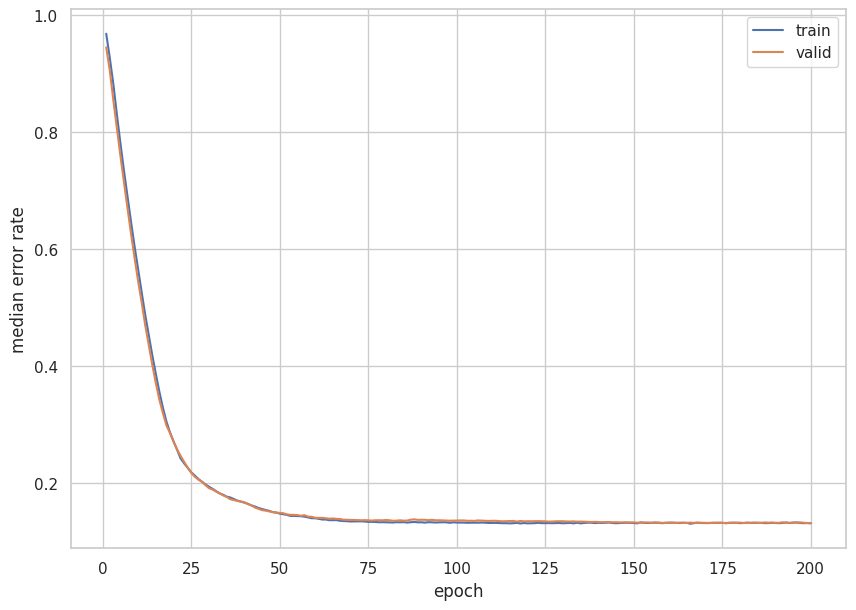

In [ ]:
plot_errors(train_errors, valid_errors)

We can see that the training error and the validation error are almost the same; hence there is no overfitting.

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations.

In [ ]:
# Build a feed-forward network
import torch.nn as nn
model = nn.Sequential(nn.Linear(train_features.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

Let's print out the model achitecture.

In [ ]:
model

Sequential(
  (0): Linear(in_features=105, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
model = model.to(device)

In [ ]:
#TODO: write code to train the MLP network
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader)

Epoch: 1/200..  Train Loss: 9.811..  Valid Loss: 3.233..  Train Median Error Rate: 0.347..  Valid Median Error Rate: 0.187.. 
Epoch: 11/200..  Train Loss: 1.713..  Valid Loss: 1.960..  Train Median Error Rate: 0.107..  Valid Median Error Rate: 0.111.. 
Epoch: 21/200..  Train Loss: 1.471..  Valid Loss: 1.871..  Train Median Error Rate: 0.099..  Valid Median Error Rate: 0.100.. 
Epoch: 31/200..  Train Loss: 1.261..  Valid Loss: 1.785..  Train Median Error Rate: 0.091..  Valid Median Error Rate: 0.100.. 
Epoch: 41/200..  Train Loss: 1.142..  Valid Loss: 1.820..  Train Median Error Rate: 0.090..  Valid Median Error Rate: 0.105.. 
Epoch: 51/200..  Train Loss: 1.023..  Valid Loss: 1.829..  Train Median Error Rate: 0.085..  Valid Median Error Rate: 0.101.. 
Epoch: 61/200..  Train Loss: 0.980..  Valid Loss: 1.861..  Train Median Error Rate: 0.088..  Valid Median Error Rate: 0.102.. 
Epoch: 71/200..  Train Loss: 0.878..  Valid Loss: 1.986..  Train Median Error Rate: 0.084..  Valid Median Error 

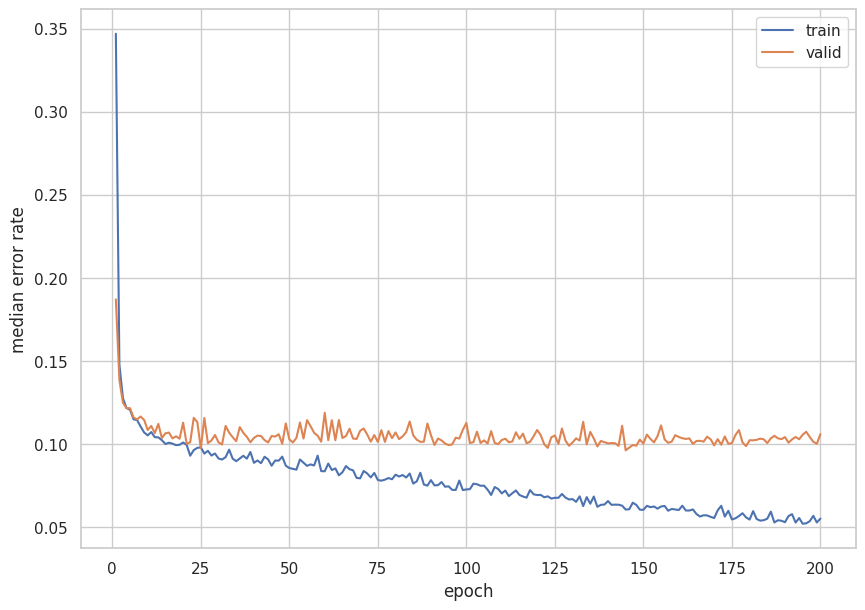

In [ ]:
#TODO: Write code to plot the training error (MER) over epochs
plot_errors(train_errors, valid_errors)

We can see that while the training error continues to decrease over epochs, the validation error saturates around 10.5% after 50 epochs. Thus, we can stop training at 50 epochs to save computation time.


We also see that the validation error of our multilayer neural network model is smaller than that of the linear regression model by roughly 2.5%.

---
## Change network architecture


For the ease of changing model architecture, we first define a class to build neural networks given the hyperparameters.

In [ ]:
import torch.nn.functional as F

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0):
        ''' Builds a feedforward network with arbitrary hidden layers.

            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers

        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])

        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])

        self.output = nn.Linear(hidden_layers[-1], output_size)

        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''

        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)

        return x

In the following, we build a MLP with 4 hidden layer of sizes 512, 256, 128, 64, respectively.  

In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128,64])
model = model.to(device)
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader)

Epoch: 1/200..  Train Loss: 9.122..  Valid Loss: 2.839..  Train Median Error Rate: 0.292..  Valid Median Error Rate: 0.167.. 
Epoch: 11/200..  Train Loss: 1.586..  Valid Loss: 1.874..  Train Median Error Rate: 0.111..  Valid Median Error Rate: 0.101.. 
Epoch: 21/200..  Train Loss: 1.192..  Valid Loss: 1.745..  Train Median Error Rate: 0.095..  Valid Median Error Rate: 0.102.. 
Epoch: 31/200..  Train Loss: 0.918..  Valid Loss: 1.907..  Train Median Error Rate: 0.083..  Valid Median Error Rate: 0.131.. 
Epoch: 41/200..  Train Loss: 0.776..  Valid Loss: 1.853..  Train Median Error Rate: 0.080..  Valid Median Error Rate: 0.104.. 
Epoch: 51/200..  Train Loss: 0.680..  Valid Loss: 2.005..  Train Median Error Rate: 0.078..  Valid Median Error Rate: 0.099.. 
Epoch: 61/200..  Train Loss: 0.604..  Valid Loss: 1.952..  Train Median Error Rate: 0.073..  Valid Median Error Rate: 0.098.. 
Epoch: 71/200..  Train Loss: 0.522..  Valid Loss: 2.051..  Train Median Error Rate: 0.068..  Valid Median Error 

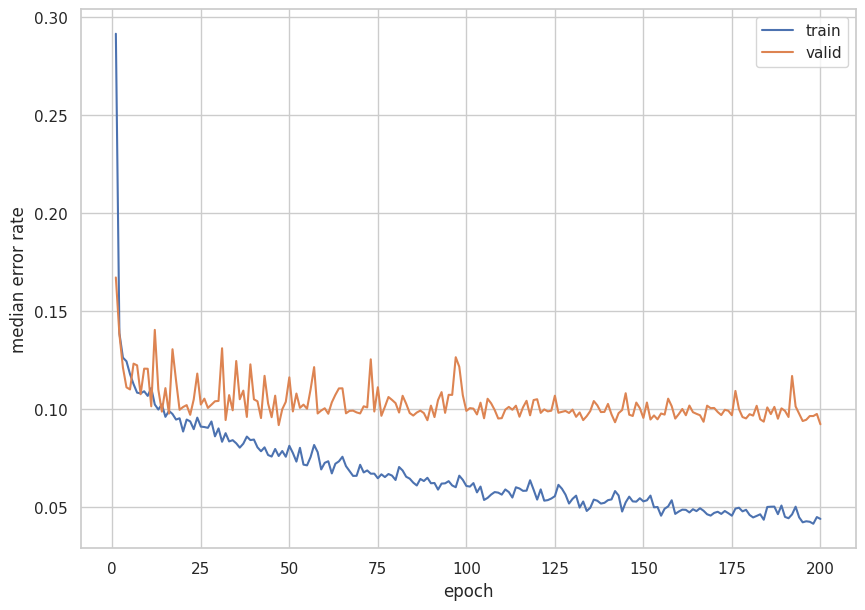

In [ ]:
plot_errors(train_errors, valid_errors)

We observe that the valid error is round 9.6%, improving by roughly 1%.

---
## Change Loss function

In the following, we change our loss funciton from MSE to [L1 Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)



In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128, 64])
model = model.to(device)

In [ ]:
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader, criterion=nn.L1Loss(), learning_rate=0.001)

Epoch: 1/200..  Train Loss: 2.112..  Valid Loss: 1.070..  Train Median Error Rate: 0.297..  Valid Median Error Rate: 0.143.. 
Epoch: 11/200..  Train Loss: 0.714..  Valid Loss: 0.793..  Train Median Error Rate: 0.085..  Valid Median Error Rate: 0.099.. 
Epoch: 21/200..  Train Loss: 0.630..  Valid Loss: 0.819..  Train Median Error Rate: 0.072..  Valid Median Error Rate: 0.101.. 
Epoch: 31/200..  Train Loss: 0.594..  Valid Loss: 0.751..  Train Median Error Rate: 0.069..  Valid Median Error Rate: 0.091.. 
Epoch: 41/200..  Train Loss: 0.558..  Valid Loss: 0.735..  Train Median Error Rate: 0.065..  Valid Median Error Rate: 0.088.. 
Epoch: 51/200..  Train Loss: 0.517..  Valid Loss: 0.731..  Train Median Error Rate: 0.059..  Valid Median Error Rate: 0.085.. 
Epoch: 61/200..  Train Loss: 0.508..  Valid Loss: 0.741..  Train Median Error Rate: 0.060..  Valid Median Error Rate: 0.088.. 
Epoch: 71/200..  Train Loss: 0.458..  Valid Loss: 0.755..  Train Median Error Rate: 0.049..  Valid Median Error 

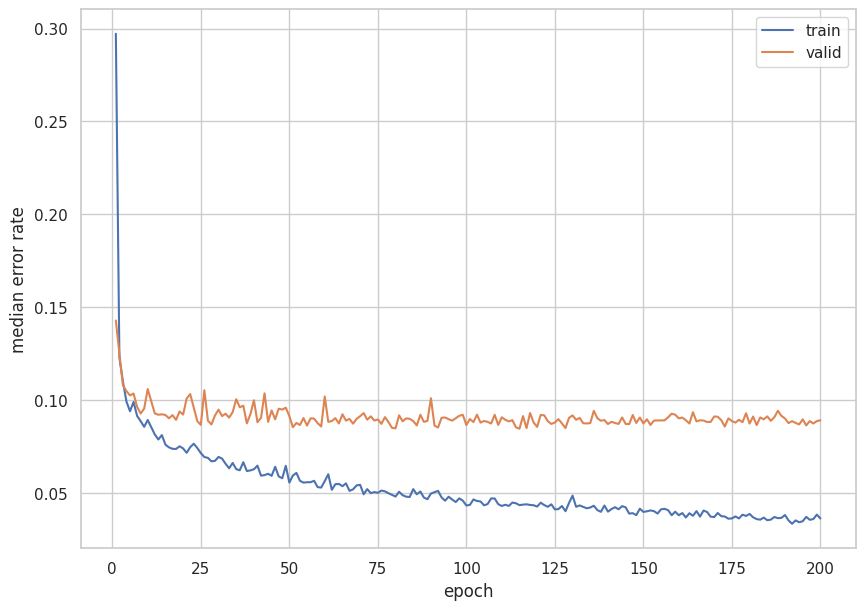

In [ ]:
plot_errors(train_errors, valid_errors)

We can see that by changing the training loss function from MSE to L1 loss, the validation error improves slightly to 9%.

---
## Norm regularization

In the following, we try to use the norm regularization

In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128, 64])
model = model.to(device)

In [ ]:
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader, criterion = nn.L1Loss(),weight_decay=0.0001)

Epoch: 1/200..  Train Loss: 1.891..  Valid Loss: 1.004..  Train Median Error Rate: 0.256..  Valid Median Error Rate: 0.135.. 
Epoch: 11/200..  Train Loss: 0.685..  Valid Loss: 0.755..  Train Median Error Rate: 0.081..  Valid Median Error Rate: 0.089.. 
Epoch: 21/200..  Train Loss: 0.615..  Valid Loss: 0.756..  Train Median Error Rate: 0.074..  Valid Median Error Rate: 0.093.. 
Epoch: 31/200..  Train Loss: 0.557..  Valid Loss: 0.750..  Train Median Error Rate: 0.065..  Valid Median Error Rate: 0.095.. 
Epoch: 41/200..  Train Loss: 0.515..  Valid Loss: 0.723..  Train Median Error Rate: 0.060..  Valid Median Error Rate: 0.087.. 
Epoch: 51/200..  Train Loss: 0.485..  Valid Loss: 0.732..  Train Median Error Rate: 0.056..  Valid Median Error Rate: 0.088.. 
Epoch: 61/200..  Train Loss: 0.456..  Valid Loss: 0.730..  Train Median Error Rate: 0.053..  Valid Median Error Rate: 0.090.. 
Epoch: 71/200..  Train Loss: 0.424..  Valid Loss: 0.728..  Train Median Error Rate: 0.049..  Valid Median Error 

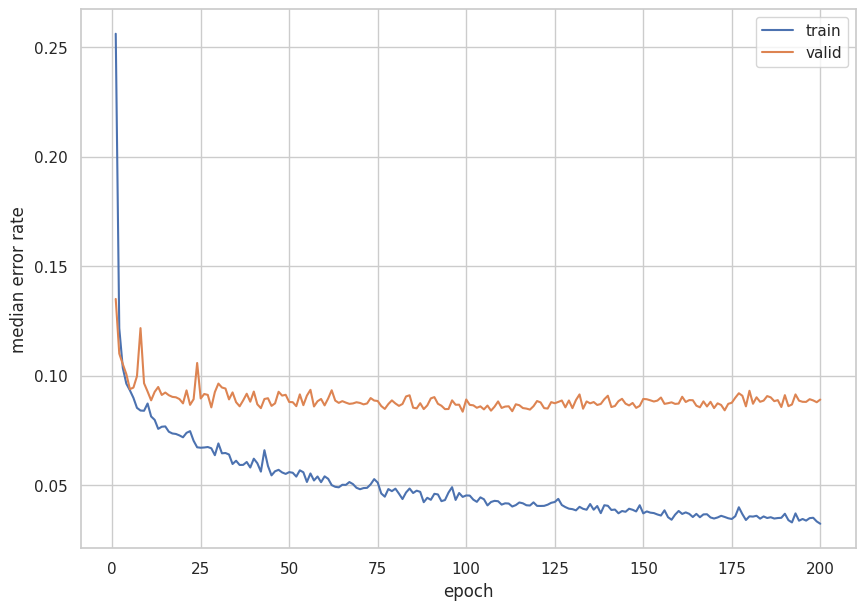

In [ ]:
plot_errors(train_errors, valid_errors)

We can see that the performance slightly improves to 8.5%.

---
## Add dropout layer


In [ ]:
drop_rate=0.05

In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128, 64],drop_p=drop_rate)
model = model.to(device)

In [ ]:
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader, criterion = nn.L1Loss(),weight_decay=0.0001)

Epoch: 1/200..  Train Loss: 1.960..  Valid Loss: 1.045..  Train Median Error Rate: 0.269..  Valid Median Error Rate: 0.140.. 
Epoch: 11/200..  Train Loss: 0.761..  Valid Loss: 0.781..  Train Median Error Rate: 0.100..  Valid Median Error Rate: 0.099.. 
Epoch: 21/200..  Train Loss: 0.698..  Valid Loss: 0.783..  Train Median Error Rate: 0.092..  Valid Median Error Rate: 0.098.. 
Epoch: 31/200..  Train Loss: 0.650..  Valid Loss: 0.732..  Train Median Error Rate: 0.086..  Valid Median Error Rate: 0.089.. 
Epoch: 41/200..  Train Loss: 0.634..  Valid Loss: 0.715..  Train Median Error Rate: 0.084..  Valid Median Error Rate: 0.088.. 
Epoch: 51/200..  Train Loss: 0.600..  Valid Loss: 0.708..  Train Median Error Rate: 0.079..  Valid Median Error Rate: 0.085.. 
Epoch: 61/200..  Train Loss: 0.566..  Valid Loss: 0.709..  Train Median Error Rate: 0.073..  Valid Median Error Rate: 0.084.. 
Epoch: 71/200..  Train Loss: 0.553..  Valid Loss: 0.716..  Train Median Error Rate: 0.074..  Valid Median Error 

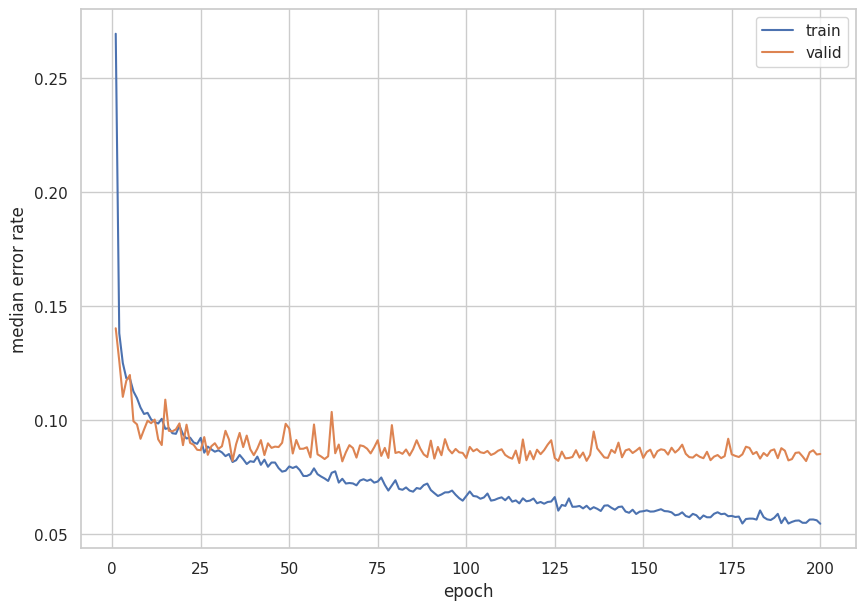

In [ ]:
plot_errors(train_errors, valid_errors)

We see that after adding the dropout layer, the valid errors become slightly smaller. Moreover, the train error and valid error stay closer.

---
## Save Model

We build a dictionary with all the information you need to compeletely rebuild the model.

In [ ]:
checkpoint = {'input_size': train_features.shape[1],
              'output_size': 1,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'drop_p': drop_rate,
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

Now the checkpoint has all the necessary information to rebuild the trained model. You can easily make that a function if you want. Similarly, we can write a function to load checkpoints.

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'],
                               checkpoint['drop_p'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [ ]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=105, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)


---
## Inference on test data

After the model is trained, we can use it for inference. We need to remember to set the model in inference mode with model.eval(). You'll also want to turn off autograd with the torch.no_grad() context.

In [ ]:
# Test our network
model = model.to(device)
model.eval()
dataiter = iter(test_loader)
features, = next(dataiter)
features=features.to(device)
output = model(features)

In [ ]:
features.shape, output.shape

(torch.Size([128, 105]), torch.Size([128, 1]))

In [ ]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    # In evaluation (or testing) mode, we don't want any parameter updates. We want the model to give
    # the final output based on current parameter values.
    pred_labels = torch.tensor([]).to(device)
    with torch.no_grad():
      for features, in test_loader:
            # Move data to device (GPU or CPU)
            features = features.to(device)
            output = model(features)  # Compute the output
            # store prediction results
            pred_labels = torch.cat( (pred_labels,output),dim=0)
    return  pred_labels

In [ ]:
pred_labels =test(model,test_loader)

In [ ]:
pred_labels.shape

torch.Size([4964, 1])

Remember when predict the price, we need to multiply back the normalization factor

In [ ]:
pred_labels=pred_labels*normalization_factor

In [ ]:
pred_labels[:20]

tensor([[ 569042.1875],
        [ 454483.5625],
        [ 494901.5000],
        [ 281509.3438],
        [ 582576.0000],
        [ 392839.8438],
        [ 385356.8125],
        [ 585982.8125],
        [ 412164.1562],
        [ 331562.6562],
        [ 365569.6875],
        [ 524865.6250],
        [ 585494.4375],
        [ 305585.7500],
        [1393625.0000],
        [ 225184.3438],
        [ 449309.6250],
        [ 207435.2812],
        [ 192029.8906],
        [1326437.0000]], device='cuda:0')

Let's store the pred_labels into submission_csv

In [ ]:
test_ID

0       144650
1       495961
2       582423
3       966643
4       795229
         ...  
4959    525377
4960    322001
4961    124447
4962     25138
4963    266845
Name: ID, Length: 4964, dtype: int64

In [ ]:
data = {'ID': test_ID, 'SALE_PRICE': pred_labels.cpu().numpy().squeeze()}
pred_df=pd.DataFrame(data)
pred_df.head()

,ID,SALE_PRICE
0,144650,569042.18750
1,495961,454483.56250
2,582423,494901.50000
3,966643,281509.34375
4,795229,582576.00000


Save the dataframe to CSV file without index by setting `index=False`.

In [ ]:
pred_df.to_csv('submission.csv', index=False)

---
## Evaluate test error

To evaluate test error, you need to have access to the true sale prices for test error.

In [ ]:
df_sol=pd.read_csv('solution.csv')
df_sol.head()


,ID,SALE_PRICE,Usage
0,144650,585000,Private
1,495961,473250,Public
2,582423,386500,Public
3,966643,270000,Private
4,795229,657500,Public


In [ ]:
test_labels=df_sol['SALE_PRICE'].values

In [ ]:
test_labels.shape

(4964,)

In [ ]:
# Compute and store median error rate for validation data
test_errors=pred_labels.cpu().numpy().squeeze()/test_labels-1
test_errors.shape

(4964,)

In [ ]:
median_test_error=np.median(np.absolute(test_errors)).item()

In [ ]:
median_test_error

0.08498112269603253

We see that the median test error is around 8.5%. Please vary model architecture or optimization algorithms to see if you can squeeze out a lower test error.

---
## Evaluate the profit of iBuyer business model

In class, we have dicussed the iBuyer business model and its opportunities and risks. In the following analysis, imagine you work in a consulting firm and would like to investigate the profitability of the iBuyer business model.

You have taken the Mordern Analytics course and remembered that Prof. X advocated the data-driven approach in business decision making. Thus, you would like to perform analysis based on model and data.

Note that since we do not know the true sale prices in the future (like test data), we need to conduct the analysis based on the historical data (train or validation data). Previously, you have already trained a multilayer perceptron model using the train data. Now, let's evaluate the profit of iBuyer business model based on the predicted prices on the **validation data**.

Let's first compute the predicted prices on the valid data.

In [ ]:
model.eval()  # Set the model to evaluation mode
pred_labels = torch.tensor([]).to(device)
valid_error_rates =torch.tensor([]).to(device)
with torch.no_grad():
  for features, labels in valid_loader:
    # Move data to device (GPU or CPU)
    features = features.to(device)
    labels=labels.to(device)
    output = model(features)  # Compute the output
    # store prediction results
    pred_labels = torch.cat( (pred_labels,output),dim=0)
    # Compute and store median error rate for validation data
    valid_error_rate = output/labels-1
    valid_error_rates= torch.cat( (valid_error_rates,valid_error_rate),dim=0)

Then we compute the validation errors. Note that crucially when we load the valid data, we choose not to shuffle the data. Thus, our pred_labels are already in one-to-one correspondence with the test labels.

In [ ]:
median_valid_error=torch.median(torch.absolute(valid_error_rates)).item()
median_valid_error

0.08697706460952759

We see that the valid error is around 8.4%.

We convert the Pytorch tensor on GPU to numpy array on CPU for ease of subsequent analysis

In [ ]:
valid_error_rates=valid_error_rates.cpu().numpy().squeeze()
pred_labels=pred_labels.cpu().numpy().squeeze()
valid_labels=valid_labels.cpu().numpy().squeeze()

Recall that `valid_idx` contains the indices for the validation data, so we get the dataframe for valid data.

In [ ]:
train_df['ID']=train_ID

In [ ]:
valid_df=train_df.iloc[valid_indices]
valid_df.head()

,NBHD,PROP_CLASS,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,STORY,STYLE_CN,UNITS,ID
5820,CENTRAL PARK,SINGLE FAMILY RESIDENCE,1705,623,792,3040,0,0,NaN,3.0,3.0,1,2.0,2 STORY,1.0,877168
1971,PLATT PARK,SINGLE FAMILY RESIDENCE,971,752,971,4690,0,109,0.0,2.0,2.0,0,1.0,1 STORY,1.0,214816
8366,MONTBELLO,SINGLE FAMILY RESIDENCE,944,0,0,7540,460,47,0.0,2.0,2.0,0,1.0,TRI-LEVEL,1.0,668804
11291,REGIS,SINGLE FAMILY RESIDENCE,903,0,903,11100,0,59,2.0,3.0,2.0,0,1.0,1 STORY,1.0,294969
3090,WASHINGTON PARK,SINGLE FAMILY RESIDENCE,3968,1200,1344,6300,0,25,0.0,4.0,4.0,3,2.0,2 STORY,1.0,384016


In [ ]:
valid_df = valid_df.reset_index(drop=True) # we reset the index
valid_df.head()

,NBHD,PROP_CLASS,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,STORY,STYLE_CN,UNITS,ID
0,CENTRAL PARK,SINGLE FAMILY RESIDENCE,1705,623,792,3040,0,0,NaN,3.0,3.0,1,2.0,2 STORY,1.0,877168
1,PLATT PARK,SINGLE FAMILY RESIDENCE,971,752,971,4690,0,109,0.0,2.0,2.0,0,1.0,1 STORY,1.0,214816
2,MONTBELLO,SINGLE FAMILY RESIDENCE,944,0,0,7540,460,47,0.0,2.0,2.0,0,1.0,TRI-LEVEL,1.0,668804
3,REGIS,SINGLE FAMILY RESIDENCE,903,0,903,11100,0,59,2.0,3.0,2.0,0,1.0,1 STORY,1.0,294969
4,WASHINGTON PARK,SINGLE FAMILY RESIDENCE,3968,1200,1344,6300,0,25,0.0,4.0,4.0,3,2.0,2 STORY,1.0,384016


Mpw. we create a new pandas dataframe `valid_df` consisting of predicted prices, true sale prices, and prediction errors for the validation data. Our subsusequent analysis will be based on the `valid_df`.

In [ ]:
valid_df["PREDICT_PRICE"]=pred_labels*normalization_factor
valid_df["SALE_PRICE"]=valid_labels*normalization_factor
valid_df["ERROR"]=valid_error_rates
valid_df.head()


,NBHD,PROP_CLASS,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,STORY,STYLE_CN,UNITS,ID,PREDICT_PRICE,SALE_PRICE,ERROR
0,CENTRAL PARK,SINGLE FAMILY RESIDENCE,1705,623,792,3040,0,0,NaN,3.0,3.0,1,2.0,2 STORY,1.0,877168,5.524467e+05,5.668210e+05,-0.025359
1,PLATT PARK,SINGLE FAMILY RESIDENCE,971,752,971,4690,0,109,0.0,2.0,2.0,0,1.0,1 STORY,1.0,214816,6.445223e+05,5.900000e+05,0.092411
2,MONTBELLO,SINGLE FAMILY RESIDENCE,944,0,0,7540,460,47,0.0,2.0,2.0,0,1.0,TRI-LEVEL,1.0,668804,2.981295e+05,2.550000e+05,0.169135
3,REGIS,SINGLE FAMILY RESIDENCE,903,0,903,11100,0,59,2.0,3.0,2.0,0,1.0,1 STORY,1.0,294969,4.125360e+05,3.170000e+05,0.301376
4,WASHINGTON PARK,SINGLE FAMILY RESIDENCE,3968,1200,1344,6300,0,25,0.0,4.0,4.0,3,2.0,2 STORY,1.0,384016,1.030017e+06,1.470000e+06,-0.299308


In [ ]:
valid_df.to_csv("valid_df.csv",index=False)


### Analysis and visualization of valid errors

Let's plot the histogram of prediction errors.

**Question 1**: what is the bias of the prediction errors? Include the histogram of prediction errors and the bias in your report.

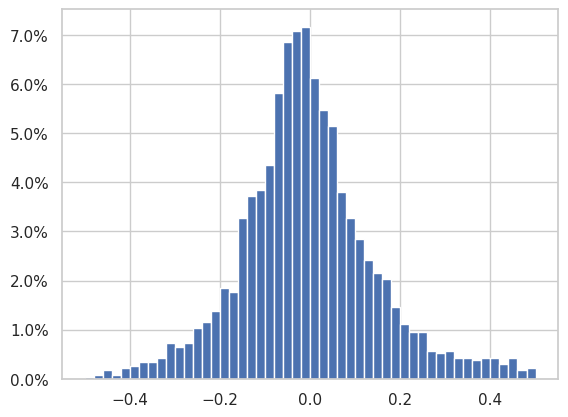

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.hist(valid_error_rates,bins=50,range=[-0.5,0.5],weights=np.ones(len(valid_error_rates)) / len(valid_error_rates))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


In [ ]:
bias=np.mean(valid_error_rates)
bias

0.025483957

We can see that the bias is relatively small, around 3%. This shows that our model is able to accurately predict the sale prices.

### Profit Analysis

**Percentage Profit**

In the following profit analysis, we assume the iBuyer will make an offer to every property in the valid data based on their predicted price $PP$. We assume  the iBuyer decides the offer price $OP$ according to
$$
OP = \frac{PP}{1+\alpha},
$$
where $\alpha$ is the (targted) profit margin of the iBuyer.
Here we assume the profit margin has already taken into consideration the commission fee charged by the iBuyer
and various costs associated such as transaction cost, administration cost, and holding cost. Note that the commission fee charged by Zillow is often around $7.5\%$ and Zillow may charge additional repair costs after home inspection. Thus we take $\alpha=12\%$ in this case study.

We further assume that the iBuyer can resell the property at the same
price as the broker in the future once the property is bought. In other words, the resell price is equal to the sale price in the valid data. This assumption may not be exactly true in practice and the iBuyer may sell the house at either a higher or lower price depending on the market trend. But our conclusion will not change too much.

Based on the above two assumptions, we can now determine the percentage profit
for a property bought by the iBuyer as
$$
\frac{SP- OP}{OP}.
$$
We use the percentage profit instead of the absolute profit because the iBuyer cannot hope to purchase all houses in the market. Therefore, the percentage profit is a better measure of the profitability of the iBuyer business model.
 The aim of the iBuyer in this simplified setting is to purchase properties for less money than they are sold for, to generate a profit.

In [ ]:
profit_margin = 0.12

**Question 2**: Consider the hypothetical scenario where the offers are all accepted regardless of their values,
what is the average percentage profit? Do you see a big difference compared to the profit margin $\alpha$? Include your answers in the report.

In [ ]:
percentage_profit_all_orders=np.mean(( valid_df['SALE_PRICE'] / (valid_df['PREDICT_PRICE'] / (1 + profit_margin)) - 1))

In [ ]:
percentage_profit_all_orders

0.14344507618513078

Here we observe that in this hypothetical scenario, the average percentage profit is 13%. It is relatively close to profit margin which is 12%.

Since the bias of the prediction is relatively small, when all offers are accepted by homeowners, the profits from purchasing underpriced properties would theoretically balance out the losses of purchasing overpriced properties. Therefore, the iBuyer will be left with the profit margin it chooses.

**Offer Acceptance Rule**

However, not every offer will be accepted by the home owner. Given an offer price, whether the homeowner accepts it
depends on the homeowner's perceived valuation, For the current dataset, we lack enough data to determine the homeowner's perceived valuation of the property. However, the actual sale price in the valid data serves as a reasonable proxy of the homeowner's perceived valuation. Therefore, we assume that the home owner will accept the offer, if
$$
OP> (1-\beta) SP,
$$
where $\beta$ is a discounting factor. Here the discounting factor captures the commission fee charged
by the conventional realtors which is around 6%, as well as the convenience factor that models
how much the homeowner values the quick transaction services of the iBuyer over the conventional
relator. We assume $\beta = 10\%$ in this case.

**Question 3**: Based on the sale price in the valid data and the acceptance rule, what is the mean percentage profit among all accepted offers? Do you see a big difference compared to the profit margin $\alpha$?  Include your answers in your report.  

In [ ]:
#TODO: compute the order_status for each property in the valid data. If the homeowner accepts the offer, the order_status=True; otherwise is False.
def order_status(data, profit_margin, conv_factor):
  if data["PREDICT_PRICE"] / (1 + profit_margin) >= data["SALE_PRICE"]  * (1 - discount_factor):
    return True
  return False

In [ ]:
discount_factor = 0.1
valid_df["ORDER_STATUS"] = valid_df.apply(lambda x: order_status(x, profit_margin, discount_factor), axis = 1)

In [ ]:
percentage_profit_accepted_orders=np.nanmean((valid_df['SALE_PRICE'] / (valid_df['PREDICT_PRICE'] / (1 + profit_margin)) - 1).where(valid_df['ORDER_STATUS'] == True))

In [ ]:
percentage_profit_accepted_orders

-0.028850339155951737

We can see that the average percentage profit for all accepted orders is -2.6%. The actual percentage profit is much lower than the target profit margin $\alpha$.

Let's plot the histogram of the prediction errors for those properties whose owners accepted the offer.

**Question 4**: What is the bias of the prediction errors when restricting to those properties whose owners accepted the offer? Based on the histogram and bias, can you explain your answers to Question 3?

In [ ]:
mask = valid_df['ORDER_STATUS'] == True
valid_errors_accepted = valid_error_rates[mask]

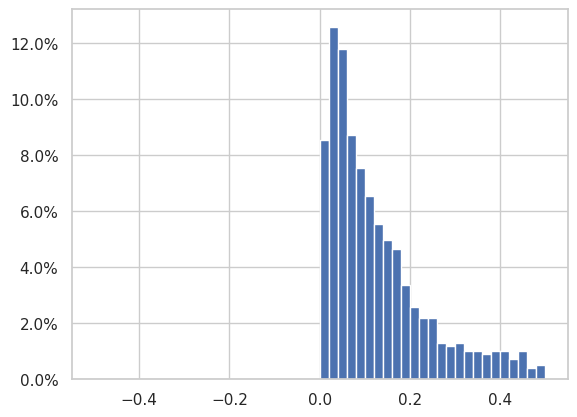

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.hist(valid_errors_accepted,bins=50,range=[-0.5,0.5],weights=np.ones(len(valid_errors_accepted)) / len(valid_errors_accepted))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [ ]:
bais_accepted = np.mean(valid_errors_accepted)
bais_accepted

0.19524376

From the above histogram and bias, we see that among all accepted offers, the predicted price tends to be higher than actual price. In other words, for the accepted offers, the houses tend to be over-priced. This leads to the issue of adverse selection, also known as the [lemon problem] (https://www.investopedia.com/terms/a/adverseselection.asp).

Even if the predictions among all houses have relatively small bias, due to the fluctuation of prediction errors, the iBuyer program would purchase more over-priced houses than under-priced ones. Moreover, the prediction errors have a heavy tail and thus there exists significantly over-priced houses. This dramatically decreases profitability. That's why our analysis reveals that the percentage profit can be even negative.

---
## Implement purchasing rules to boost the percentage profit (Optional)

The following analysis is optional and there is no need to understand it for this class.


To mitigate the impact of the adverse selection, we need to decrease the variability
of the prediction error. In practice, we may ask agents to inspect the house and collect more
information. This helps mitigate the information asymmetry.
Alternatively, we can purchase those houses with small prediction errors. For example, we can
categorize the houses according to neighborhoods, sizes, and price ranges. Then we compute
the valid error for different categories. The aim is to find out whether the predictive models
are less informed about the house price for certain categories. Then we only purchase the
categories with small validation errors.
We remark that the iBuyer also prefers to purchase more liquid houses in practice. This helps
reduce the uncertainty and holding cost till the iBuyer resells the house.


Let's compute sale prices statistics across different neighborhoods

In [ ]:
sale_price_NBHD = valid_df.groupby(["NBHD"])["SALE_PRICE"].describe()
sale_price_NBHD

,count,mean,std,min,25%,50%,75%,max
NBHD,,,,,,,,
ATHMAR PARK,27.0,330870.370512,47369.465113,250000.000000,300549.995899,326999.998093,352749.991417,4.840000e+05
BAKER,8.0,518309.757113,106527.040547,354999.995232,447500.014305,524500.012398,582483.518124,6.950000e+05
BARNUM,21.0,297161.907809,98561.815411,110000.002384,225000.000000,304999.995232,345000.004768,4.965000e+05
BARNUM WEST,8.0,329362.505674,56315.136910,268000.006676,279749.995470,331500.005722,353675.007820,4.340000e+05
BEAR VALLEY,22.0,334895.454212,116662.657315,102999.997139,332499.998808,374950.003624,407249.993086,4.680000e+05
...,...,...,...,...,...,...,...,...
WEST COLFAX,34.0,527151.881947,144821.118897,170000.004768,454924.988747,499950.003624,559999.990463,9.946140e+05
WEST HIGHLAND,28.0,663807.856185,337780.296621,339000.010490,458499.991894,579999.995232,708499.979973,1.850000e+06
WESTWOOD,27.0,264752.371002,81143.764262,69999.998808,215575.003624,290000.009537,310999.989510,4.100000e+05


In [ ]:
sale_price_NBHD.to_csv("sale_price_NBHD.csv")

Let's compute the summary statistics of some key features

In [ ]:
feature_list = ["SALE_PRICE", "BED_RMS", "STORY", "LIVING_SQFT", "LAND_SQFT"]
feature_stat = valid_df.loc[:,feature_list].describe().transpose()
feature_stat

,count,mean,std,min,25%,50%,75%,max
SALE_PRICE,2317.0,504912.011437,286711.234949,69999.998808,317000.007629,430000.019073,605000.019073,1.995000e+06
BED_RMS,2317.0,2.459215,0.895536,0.000000,2.000000,2.000000,3.000000,6.000000e+00
STORY,2317.0,1.483384,0.650033,1.000000,1.000000,1.000000,2.000000,4.000000e+00
LIVING_SQFT,2317.0,1460.172205,718.146661,315.000000,956.000000,1272.000000,1767.000000,6.505000e+03
LAND_SQFT,2317.0,3901.309020,3383.112273,0.000000,0.000000,3750.000000,6250.000000,3.198700e+04


In [ ]:
feature_stat.to_csv("feature_stat.csv")

Let's now compute the prediction errros across different neighborhoods

In [ ]:
valid_df['ABS_ERROR'] = np.abs(valid_df['ERROR'])

In [ ]:
error_NBHD = pd.DataFrame({"Counts": valid_df.groupby(["NBHD"])["ABS_ERROR"].count(),
              "Errors": valid_df.groupby(["NBHD"])["ABS_ERROR"].median()})
error_NBHD

,Counts,Errors
NBHD,,
ATHMAR PARK,27,0.066516
BAKER,8,0.050818
BARNUM,21,0.154535
BARNUM WEST,8,0.109939
BEAR VALLEY,22,0.089175
...,...,...
WEST COLFAX,34,0.061375
WEST HIGHLAND,28,0.172502
WESTWOOD,27,0.144388


In [ ]:
error_NBHD.to_csv("error_NBHD.csv")

Let's now compute the prediction erros across building year groups.

In [ ]:
year_range = valid_df["BLDG_AGE"].max() - valid_df["BLDG_AGE"].min()
year_group = 10
year_bins = [valid_df["BLDG_AGE"].min() + year_range / year_group * bin_index for bin_index in range(1, year_group + 1)]
year_cuts = pd.cut(valid_df["BLDG_AGE"], [valid_df["BLDG_AGE"].min()] + year_bins, right = True, include_lowest = True)

In [ ]:
error_year = pd.DataFrame({"Counts": valid_df.groupby(year_cuts)["ABS_ERROR"].count(),
              "Errors": valid_df.groupby(year_cuts)["ABS_ERROR"].median()})
error_year

,Counts,Errors
BLDG_AGE,,
"(-0.001, 13.7]",675,0.065893
"(13.7, 27.4]",243,0.063222
"(27.4, 41.1]",177,0.077436
"(41.1, 54.8]",279,0.097763
"(54.8, 68.5]",381,0.106992
"(68.5, 82.2]",185,0.115157
"(82.2, 95.9]",113,0.107372
"(95.9, 109.6]",104,0.123412
"(109.6, 123.3]",87,0.110370


In [ ]:
error_year.to_csv("error_year.csv")

Let's compute the prediction errors across different LIVING_SQFT

In [ ]:
area_mean = np.mean(valid_df["LIVING_SQFT"])
area_std = np.std(valid_df["LIVING_SQFT"])
area_bins = [area_mean + area_std * bin_index / 10 for bin_index in range(-10, 21, 5)]
area_cuts = pd.cut(valid_df["LIVING_SQFT"], [valid_df["LIVING_SQFT"].min()] + area_bins + [valid_df["LIVING_SQFT"].max()],
           right = True, include_lowest = True)

In [ ]:
area_std_bins = ["(" + str(bin_index / 10) + ", " + str((bin_index + 5) / 10) + "]" for bin_index in range(-10, 16, 5)]
area_std_bins.insert(0, "<= -1.0")
area_std_bins.append(">= 2.0")

In [ ]:
error_area = pd.DataFrame({"Counts": valid_df.groupby(area_cuts)["ABS_ERROR"].count(),
              "Errors": valid_df.groupby(area_cuts)["ABS_ERROR"].median()})
error_area.insert(loc = 0, column = 'LIVING_SQFT STD', value = area_std_bins)
error_area

,LIVING_SQFT STD,Counts,Errors
LIVING_SQFT,,,
"(314.999, 742.181]",<= -1.0,188,0.084938
"(742.181, 1101.176]","(-1.0, -0.5]",667,0.084899
"(1101.176, 1460.172]","(-0.5, 0.0]",580,0.089612
"(1460.172, 1819.168]","(0.0, 0.5]",335,0.076443
"(1819.168, 2178.164]","(0.5, 1.0]",228,0.071156
"(2178.164, 2537.16]","(1.0, 1.5]",132,0.095481
"(2537.16, 2896.156]","(1.5, 2.0]",71,0.113425
"(2896.156, 6505.0]",>= 2.0,116,0.138891


In [ ]:
error_area.to_csv("error_living.csv")

Let's compute the prediction errros across different price groups

In [ ]:
price_mean = np.mean(valid_df["SALE_PRICE"])
price_std = np.std(valid_df["SALE_PRICE"])
price_bins = [price_mean + price_std * bin_index / 10 for bin_index in range(-10, 21, 5)]
price_cuts = pd.cut(valid_df["SALE_PRICE"], [valid_df["SALE_PRICE"].min()] + price_bins + [valid_df["SALE_PRICE"].max()],
           right = True, include_lowest = True)

In [ ]:
price_std_bins = ["(" + str(bin_index / 10) + ", " + str((bin_index + 5) / 10) + "]" for bin_index in range(-10, 16, 5)]
price_std_bins.insert(0, "<= -1.0")
price_std_bins.append(">= 2.0")

In [ ]:
error_price = pd.DataFrame({"Counts": valid_df.groupby(price_cuts)["ABS_ERROR"].count(),
              "Errors": valid_df.groupby(price_cuts)["ABS_ERROR"].median()})
error_price.insert(loc = 0, column = 'SALE_PRICE STD', value = price_std_bins)

In [ ]:
error_price

,SALE_PRICE STD,Counts,Errors
SALE_PRICE,,,
"(69999.99799999999, 218262.654]",<= -1.0,192,0.101449
"(218262.654, 361587.333]","(-1.0, -0.5]",648,0.075086
"(361587.333, 504912.011]","(-0.5, 0.0]",574,0.077821
"(504912.011, 648236.69]","(0.0, 0.5]",403,0.073122
"(648236.69, 791561.368]","(0.5, 1.0]",209,0.115908
"(791561.368, 934886.047]","(1.0, 1.5]",109,0.093804
"(934886.047, 1078210.726]","(1.5, 2.0]",69,0.110747
"(1078210.726, 1995000.076]",>= 2.0,113,0.150535


In [ ]:
error_price.to_csv("error_price.csv")

Mean percentage profit of all accepted offers

In [ ]:
def order_status(data, profit_margin, conv_factor):
  if data["PREDICT_PRICE"] / (1 + profit_margin) >= data["SALE_PRICE"]  * (1 - conv_factor):
    return True
  return False

In [ ]:
profit_margin = 0.12
conv_factor = 0.10
valid_df["ORDER_STATUS"] = valid_df.apply(lambda x: order_status(x, profit_margin, conv_factor), axis = 1)

In [ ]:
percentage_profit_accepted_orders=np.nanmean((valid_df['SALE_PRICE'] / (valid_df['PREDICT_PRICE'] / (1 + profit_margin)) - 1).where(valid_df['ORDER_STATUS'] == True))

In [ ]:
percentage_profit_accepted_orders


-0.028850339155951737

Accepted offers in 20 neighborhoods with the lowest prediction errors

In [ ]:
selected_NBHD = error_NBHD.nsmallest(20, "Errors").index
selected_NBHD_orders = valid_df.loc[np.where((valid_df['ORDER_STATUS'] == True) & (valid_df['NBHD'].isin(selected_NBHD)))]

In [ ]:
# count orders
np.count_nonzero(~np.isnan(valid_df['SALE_PRICE'].where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['NBHD'].isin(selected_NBHD)))))

325

In [ ]:
percentage_profit_selected_NBHD_orders=np.nanmean((valid_df['SALE_PRICE'] / (valid_df['PREDICT_PRICE'] / (1 + profit_margin)) - 1).where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['NBHD'].isin(selected_NBHD))))

In [ ]:
percentage_profit_selected_NBHD_orders

0.010745520831349843

 Accepted offers within (-0.5, 0.5] STD of LIVING_SQFT

In [ ]:
selected_area_left = error_area.loc[error_area["LIVING_SQFT STD"] == "(-0.5, 0.0]"].index[0].left
selected_area_right = error_area.loc[error_area["LIVING_SQFT STD"] == "(0.0, 0.5]"].index[0].right

In [ ]:
# count orders
np.count_nonzero(~np.isnan(valid_df['SALE_PRICE'].where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['LIVING_SQFT'].between(selected_area_left, selected_area_right)))))

378

In [ ]:
percentage_profit_selected_LIVNG_orders=np.nanmean((valid_df['SALE_PRICE'] / (valid_df['PREDICT_PRICE'] / (1 + profit_margin)) - 1).where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['LIVING_SQFT'].between(selected_area_left, selected_area_right))))

In [ ]:
percentage_profit_selected_LIVNG_orders

-0.025538517656989414

 Accepted orders within (-0.5, 0.5] STD of SALE_PRICE

In [ ]:
selected_price_left = error_price.loc[error_price["SALE_PRICE STD"] == "(-0.5, 0.0]"].index[0].left
selected_price_right = error_price.loc[error_price["SALE_PRICE STD"] == "(0.0, 0.5]"].index[0].right

In [ ]:
# count orders
np.count_nonzero(~np.isnan(valid_df['SALE_PRICE'].where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['SALE_PRICE'].between(selected_price_left, selected_price_right)))))

402

In [ ]:
percentage_profit_selected_price_orders=np.nanmean((valid_df['SALE_PRICE'] / (valid_df['PREDICT_PRICE'] / (1 + profit_margin)) - 1).where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['SALE_PRICE'].between(selected_price_left, selected_price_right))))

In [ ]:
percentage_profit_selected_price_orders

-0.015779077706384523

 Accepted offers satisfying all above rules

In [ ]:
# count orders
np.count_nonzero(~np.isnan(valid_df['SALE_PRICE'].where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['NBHD'].isin(selected_NBHD)) &
     (valid_df['LIVING_SQFT'].between(selected_area_left, selected_area_right)) &
      (valid_df['SALE_PRICE'].between(selected_price_left, selected_price_right)))))

50

In [ ]:
percentage_profit_selected_all_orders=np.nanmean((valid_df['SALE_PRICE'] / (valid_df['PREDICT_PRICE'] / (1 + profit_margin)) - 1).where(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['NBHD'].isin(selected_NBHD)) &
     (valid_df['LIVING_SQFT'].between(selected_area_left, selected_area_right)) &
      (valid_df['SALE_PRICE'].between(selected_price_left, selected_price_right))))

In [ ]:
percentage_profit_selected_all_orders

0.03284557498957381

In [ ]:
errors=valid_df['ERROR']

In [ ]:
mask=(
    (valid_df['ORDER_STATUS'] == True) & (valid_df['NBHD'].isin(selected_NBHD)) &
     (valid_df['LIVING_SQFT'].between(selected_area_left, selected_area_right)) &
      (valid_df['SALE_PRICE'].between(selected_price_left, selected_price_right)))

In [ ]:
errors_all_order=errors[mask]

In [ ]:
len(errors_all_order)

50

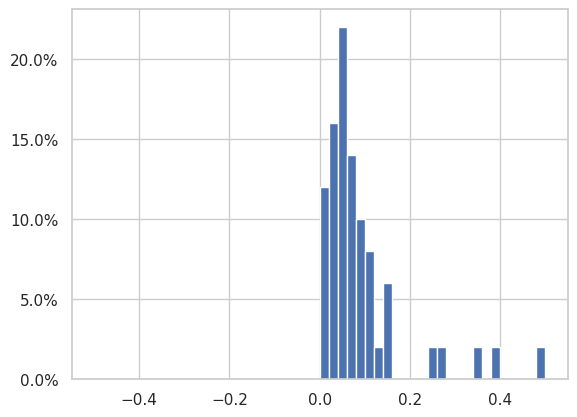

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.hist(errors_all_order,bins=50,range=[-0.5,0.5],weights=np.ones(len(errors_all_order)) / len(errors_all_order))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

We see that after imposing the purchasing rules, we increase the average percentage profit from -2.6% to 3%. However, this is still far from the profit margin $\alpha=12\%$. This is because the purchasing rules can only mitigate but not fully resolve the adverse selection issue.

---
## Wrapping up

Here is what you should take away from this case:

- Regression is done using different loss functions than we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.

- Evaluation metrics can be different from the loss function used for training. For example, we use median error rate in this case.

- When features in the input data have values in different ranges, each feature
should be scaled independently as a preprocessing step

- You can optimize the model hyperparameters to achieve lower valid error.

- Even though the predicted price tends to be relatively accurate with small bias, we still need to worry about the uncertainty in the prediction. In particular, the iBuyer business model is exposed to adverse selection and can even lose money even if it bids houses lower than the predicted price with a significant profit margin.  

- We can implement purchase rules to decrase the variability of the prediction errors and mitigate the impact of the adverse selection.